In [21]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

from sklearn.model_selection import train_test_split

In [22]:
def reduction_memory(df: pd.DataFrame) -> pd.DataFrame:
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[df_c[column].notna()][column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    mb_before = df.memory_usage().sum() * 1e-6
    mb_after = df_c.memory_usage().sum() * 1e-6
    mb_reduced = mb_before - mb_after
    
    print(f'before:\t\t{round(mb_before, 2)} mb\n', 
          f'after:\t\t{round(mb_after, 2)} mb\n',
          f'reduсed:\t{round(mb_reduced, 2)} mb',
          sep='')
    
    return df_c

In [23]:
PATH_TO_FILE = '../input/ml-in-business/freMPL-R.csv'

In [24]:
df = pd.read_csv(PATH_TO_FILE, low_memory=False)
df = df.drop_duplicates()
df = reduction_memory(df)

df.head()

before:		62.22 mb
after:		44.72 mb
reduсed:	17.5 mb


,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Разбиение датасета на train/val/test

In [25]:
X_df = df.drop('ClaimInd', axis=1)
y_df = df['ClaimInd']

x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, 
                                                    test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, 
                                                    test_size=0.5, random_state=42)

## Преобразование в H2O-Frame

In [26]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 mins 04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_unknownUser_v5lfhv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.982 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [27]:
h2o_train = h2o.H2OFrame(pd.concat([x_train, y_train], axis=1))
h2o_valid = h2o.H2OFrame(pd.concat([x_valid, y_valid], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([x_test, y_test], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

In [28]:
h2o_y_train = h2o_train['ClaimInd'].asfactor()
h2o_y_valid = h2o_valid['ClaimInd'].asfactor()
h2o_y_test = h2o_test['ClaimInd'].asfactor()

## Инициализируем и обучим GLM модель c кросс-валидацией

## Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

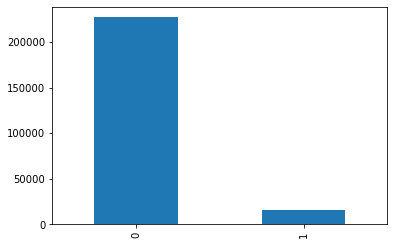

In [29]:
df['ClaimInd'].value_counts().plot(kind='bar')

In [30]:
glm_poisson = H2OGeneralizedLinearEstimator(family = "binomial", link = "logit", nfolds=5, balance_classes=True)
glm_poisson.train(y="ClaimInd", x = h2o_train.names[:-1], training_frame = h2o_train, validation_frame = h2o_valid)

glm_poisson.summary()

glm Model Build progress: |███████████████████████████████████████████████| 100%

GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.007E-4 )",190,56,8,Key_Frame__upload_b6141e37310321f2386c113f327b4952.hex


## Метрики качества модели - по всем данным и на кросс-валидации

In [31]:
glm_poisson.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9930763,0.0015092925,0.991764,0.9922026,0.9924874,0.9955659,0.99336195
1,auc,0.9915241,0.0028169642,0.99052036,0.9897966,0.9885935,0.99560654,0.9931035
2,aucpr,0.9636172,0.010884188,0.9554441,0.95699775,0.9575618,0.9814324,0.9666499
3,err,0.0069236513,0.0015092925,0.008235982,0.0077974442,0.007512619,0.004434134,0.006638078
4,err_count,235.6,51.40331,282.0,263.0,256.0,151.0,226.0
5,f0point5,0.9687971,0.0040886695,0.96615154,0.96645683,0.96682197,0.9759014,0.9686539
6,f1,0.94486225,0.012224054,0.9352914,0.9372764,0.94079554,0.96564275,0.94530493
7,f2,0.9221869,0.019735843,0.90634173,0.9098065,0.9161337,0.9555976,0.9230551
8,lift_top_group,15.278794,0.34957045,14.91939,15.317439,15.084551,15.229875,15.842717
9,logloss,0.05365657,0.007926403,0.058105756,0.058003347,0.057644233,0.03968156,0.054847952


## Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

In [32]:
glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-5.137373,-4.328627
1,SocioCateg.CSP1,-0.077494,-0.077494
2,SocioCateg.CSP16,0.000000,0.000000
3,SocioCateg.CSP18,0.000000,0.000000
4,SocioCateg.CSP19,0.000000,0.000000
...,...,...,...
186,ClaimNbParking,0.046408,0.013487
187,ClaimNbFireTheft,-0.017748,-0.004993
188,ClaimNbWindscreen,0.145939,0.094316
189,OutUseNb,0.066617,0.045877


## Таблица нормированных коэффициентов по всем данным и на кросс-валидации

In [33]:
pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()
for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
coef = pd.DataFrame.from_dict(pmodels).round(5)
coef['overall'] = abs(coef['overall'])
coef.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
ClaimAmount,25.26129,23.22294,23.31425,23.27915,20.60776,23.27954
Intercept,4.32863,-4.31913,-4.37977,-4.32382,-3.93502,-4.40729
VehAge.nan,2.11180,2.01844,1.98547,2.01896,1.70323,2.01816
DeducType.nan,0.82678,0.70223,0.79193,0.76827,0.74419,0.81491
Exposure,0.44774,0.45670,0.42888,0.45821,0.46408,0.43747
...,...,...,...,...,...,...
VehPrice.O,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
VehPrice.P,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
VehPrice.Q,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
VehPrice.R,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Построение прогнозных значений для обучающей, валидационной и тестовой выборок

In [34]:
y_train_pred = glm_poisson.predict(h2o_train).as_data_frame()
y_valid_pred = glm_poisson.predict(h2o_valid).as_data_frame()
y_test_pred = glm_poisson.predict(h2o_test).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'SocioCateg' has levels not trained on: [CSP17]
  warnings.warn(w)


glm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'SocioCateg' has levels not trained on: [CSP17, CSP9]
  warnings.warn(w)


## Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок

In [35]:
y_train_pred

,predict,p0,p1
0,0,0.983224,0.016776
1,0,0.985533,0.014467
2,1,0.546088,0.453912
3,0,0.959196,0.040804
4,0,0.998780,0.001220
...,...,...,...
170140,0,0.973014,0.026986
170141,0,0.998109,0.001891
170142,1,0.034958,0.965042
170143,0,0.955088,0.044912


In [36]:
# accuracy_score, f1_score, confusion_matrix
def evaluete_pred(true, pred):
    accuracy = accuracy_score(true, pred['predict'])
    f1 = f1_score(true, pred['predict'])
    confusions = confusion_matrix(true, pred['predict'])
    confusions = pd.DataFrame(confusions, columns=['P', 'N'], index=['P', 'N'])

    print(f'точность:\t{accuracy}')
    print(f'f1:\t\t{f1}')
    print(f'матрица конфигураций:\n{confusions}')

In [37]:
evaluete_pred(y_train, y_train_pred)

точность:	0.9933879925945517
f1:		0.9473585700248
матрица конфигураций:
        P      N
P  158897    107
N    1018  10123


In [38]:
evaluete_pred(y_test, y_test_pred)

точность:	0.9931431705979156
f1:		0.945151382185169
матрица конфигураций:
       P     N
P  34056    17
N    233  2154


In [39]:
evaluete_pred(y_valid, y_valid_pred)

точность:	0.9931705979155239
f1:		0.9449966865473824
матрица конфигураций:
       P     N
P  34072    13
N    236  2139


## Какие проблемы вы здесь видите? Как можно улучшить данный результат?

Основная проблема заключалась в сильном дисбалансе классов, а так же в огромном количестве пропусков, что нужно обрабатывать